In [10]:
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import contextily as ctx

df = pd.read_csv("apartments.csv")
pts_col = []
for pt in df[["XCoord", "YCoord"]].itertuples():
    pts_col.append(Point(pt.XCoord, pt.YCoord))
df["geometry"] = pts_col
df = df[["Address", "PropertyUse", "geometry"]]
df = gpd.GeoDataFrame(df)
df = df.set_crs("esri:103412")
df = df.to_crs(epsg=4326)
#base = df.plot(markersize=0.1, figsize=(20,20))

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (28,43,105) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [21]:
census_df = pd.read_csv("census/sex_age.csv")
census_df["GEO_ID"] = census_df["GEO_ID"] 
census_df = census_df[["GEO_ID", "NAME", "P012001", "P012004", "P012005", "P012006", "P012007"]]
census_df = census_df.rename(columns = {"NAME":"Area", "P012001": "Total", "P012004": "5-9yr", "P012005": "10-14yr", "P012006": "15-17yr", "P012007": "18-19yr"}, inplace=False)
census_df = census_df[1:]
census_df["Total"] = census_df["Total"].astype(int)
census_df["5-9yr"] = census_df["5-9yr"].astype(int)
census_df["10-14yr"] = census_df["10-14yr"].astype(int)
census_df["15-17yr"] = census_df["15-17yr"].astype(int)
census_df["18-19yr"] = census_df["18-19yr"].astype(int)
census_df["K-12"] = census_df["5-9yr"] + census_df["10-14yr"] + census_df["15-17yr"] + census_df["18-19yr"]
census_df = census_df[census_df["K-12"] != 0]
census_df

,GEO_ID,Area,Total,5-9yr,10-14yr,15-17yr,18-19yr,K-12
2,1000000US550250012003019,"Block 3019, Block Group 3, Census Tract 12, Da...",22,0,0,1,0,1
3,1000000US550250125021027,"Block 1027, Block Group 1, Census Tract 125.02...",25,1,1,0,0,2
4,1000000US550250008002013,"Block 2013, Block Group 2, Census Tract 8, Dan...",40,1,1,0,0,2
6,1000000US550250131002034,"Block 2034, Block Group 2, Census Tract 131, D...",26,0,3,1,0,4
8,1000000US550250122021016,"Block 1016, Block Group 1, Census Tract 122.02...",99,3,4,1,0,8
...,...,...,...,...,...,...,...,...
12559,1000000US550250131001017,"Block 1017, Block Group 1, Census Tract 131, D...",6,0,0,1,1,2
12560,1000000US550250121003068,"Block 3068, Block Group 3, Census Tract 121, D...",43,3,3,1,1,8
12561,1000000US550250132002029,"Block 2029, Block Group 2, Census Tract 132, D...",19,0,1,0,0,1
12566,1000000US550250002021012,"Block 1012, Block Group 1, Census Tract 2.02, ...",75,1,3,2,0,6


In [4]:
# spatial join - take dataset A + dataset B = dataset AB, based on space/geographic relationship
# two datasets must have a matched CRS: coordinate reference system

dane = gpd.read_file("dane/dane.shp")
dane["GEO_ID"] = "1000000US" + dane["GEOID20"] 
dane.head()

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,GEO_ID
0,55,025,002900,2006,550250029002006,Block 2006,G5040,None,None,None,S,38858,0,+43.0614916,-089.3182030,"POLYGON ((-89.31992 43.06209, -89.31823 43.062...",1000000US550250029002006
1,55,025,012700,1050,550250127001050,Block 1050,G5040,None,None,None,S,1055458,0,+43.0221242,-089.8262570,"POLYGON ((-89.83427 43.02107, -89.83427 43.021...",1000000US550250127001050
2,55,025,011404,4001,550250114044001,Block 4001,G5040,None,None,None,S,47453,0,+43.1937131,-089.2948433,"POLYGON ((-89.29664 43.19458, -89.29664 43.194...",1000000US550250114044001
3,55,025,000504,3015,550250005043015,Block 3015,G5040,None,None,None,S,8739,0,+43.0307340,-089.5300742,"POLYGON ((-89.53060 43.03119, -89.52971 43.031...",1000000US550250005043015
4,55,025,001200,4020,550250012004020,Block 4020,G5040,None,None,None,S,7686,0,+43.0644947,-089.4064235,"POLYGON ((-89.40721 43.06476, -89.40698 43.064...",1000000US550250012004020


In [22]:
dane.to_crs(df.crs, inplace=True)
block_with_apartment = gpd.sjoin(df, dane, how="left", op="within")
block_with_apartment.head()

,Address,PropertyUse,geometry,index_right,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,GEO_ID
0,5109 Golden Leaf Trl,Single family,POINT (-89.29546 43.11162),6274,55,025,002603,3044,550250026033044,Block 3044,G5040,None,None,None,S,47251,0,+43.1114287,-089.2938967,1000000US550250026033044
1,5121 Golden Leaf Trl,Single family,POINT (-89.29451 43.11144),6274,55,025,002603,3044,550250026033044,Block 3044,G5040,None,None,None,S,47251,0,+43.1114287,-089.2938967,1000000US550250026033044
2,921 Twin Pines Dr,Single family,POINT (-89.29202 43.11115),5404,55,025,002603,3043,550250026033043,Block 3043,G5040,None,None,None,S,45078,0,+43.1099491,-089.2927798,1000000US550250026033043
3,918 Eagle Crest Dr,Single family,POINT (-89.29157 43.11131),5404,55,025,002603,3043,550250026033043,Block 3043,G5040,None,None,None,S,45078,0,+43.1099491,-089.2927798,1000000US550250026033043
4,5105 Wintergreen Dr,Single family,POINT (-89.29568 43.10703),3832,55,025,002603,3041,550250026033041,Block 3041,G5040,None,None,None,S,55550,0,+43.1072080,-089.2925655,1000000US550250026033041


In [24]:
merged = pd.merge(block_with_apartment, census_df, on="GEO_ID")
merged = merged[["Address", "PropertyUse", "geometry", "GEOID20", "NAME20", "Total", "5-9yr", "10-14yr", "15-17yr", "18-19yr", "K-12"]]
K12_df = merged
merged

# Problem of this dataframe:
# 1. Duplicate blocks. Cannot specify which aperment has k-12 kids. Only blockwise data of k-12 kids.
# 2. Lack geometry for blocks, cannot plot blockwise.
# 3. K-12 kids are in age range of 5-18, but 18-19 year-old kids are combined into a single column in original datasets.

,Address,PropertyUse,geometry,GEOID20,NAME20,Total,5-9yr,10-14yr,15-17yr,18-19yr,K-12
0,701 N Thompson Dr,4 unit Apartment,POINT (-89.30020 43.10692),550250026031004,Block 1004,58,3,2,0,0,5
1,711 N Thompson Dr,4 unit Apartment,POINT (-89.30002 43.10776),550250026031004,Block 1004,58,3,2,0,0,5
2,715 N Thompson Dr Unit CDM,Condominium,POINT (-89.29971 43.10802),550250026031004,Block 1004,58,3,2,0,0,5
3,715 N Thompson Dr,Condominium,POINT (-89.29971 43.10802),550250026031004,Block 1004,58,3,2,0,0,5
4,717 N Thompson Dr,Condominium,POINT (-89.29971 43.10802),550250026031004,Block 1004,58,3,2,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...
38655,9026 Bentley Green,Condominium,POINT (-89.53991 43.04147),550250109031015,Block 1015,30,3,1,1,0,5
38656,9024 Bentley Green,Condominium,POINT (-89.53991 43.04147),550250109031015,Block 1015,30,3,1,1,0,5
38657,2141 Middleton Beach Rd Unit MSN,Other,POINT (-89.48268 43.09456),550250111013002,Block 3002,65,6,2,0,1,9
38658,1501 Moorland Rd,Mobile home park,POINT (-89.35825 43.03195),550250015023001,Block 3001,88,2,0,0,1,3


## Blocks of Apartments That Have K-12 Kids

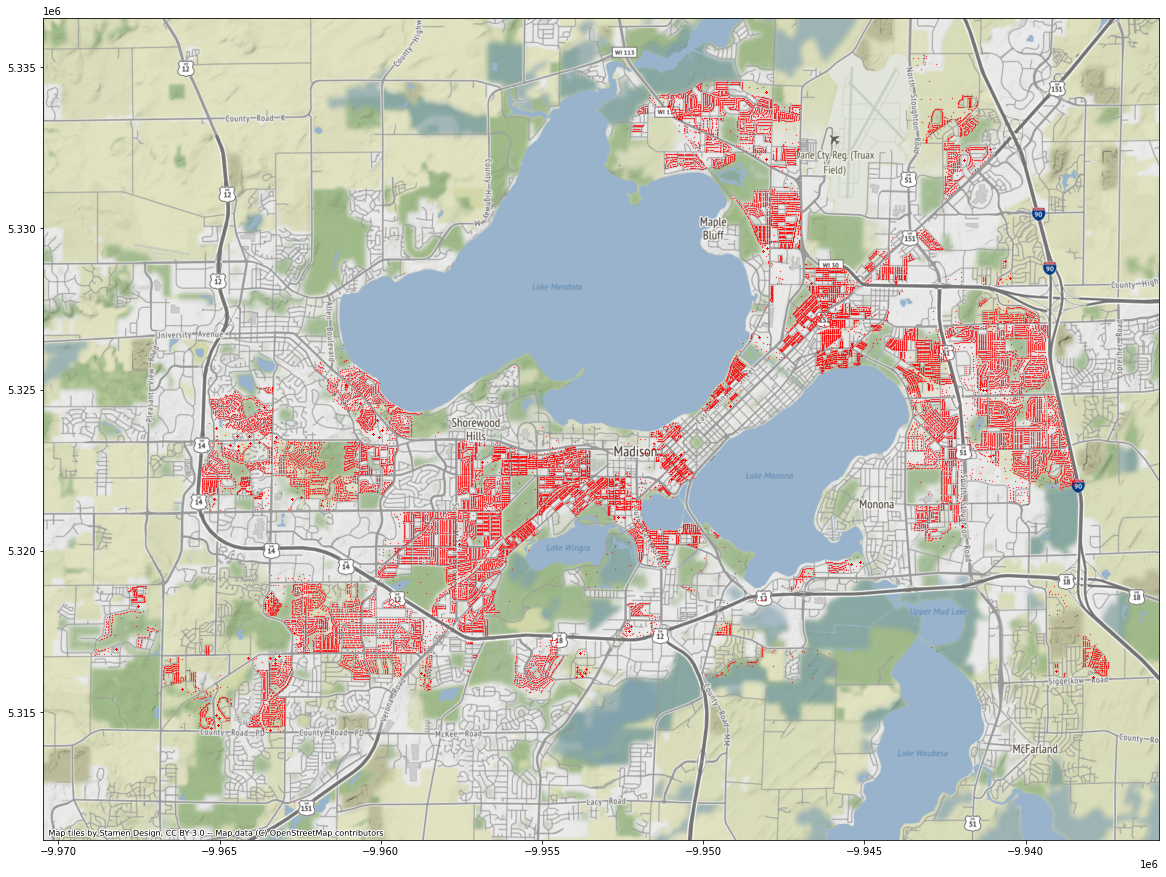

In [12]:
K12_df = K12_df.to_crs(epsg=3857)
ax_k12 = K12_df.plot(markersize=0.1, figsize=(20,20), color="red")
ax2 = ctx.add_basemap(ax_k12)

## Apartments in City of Madison

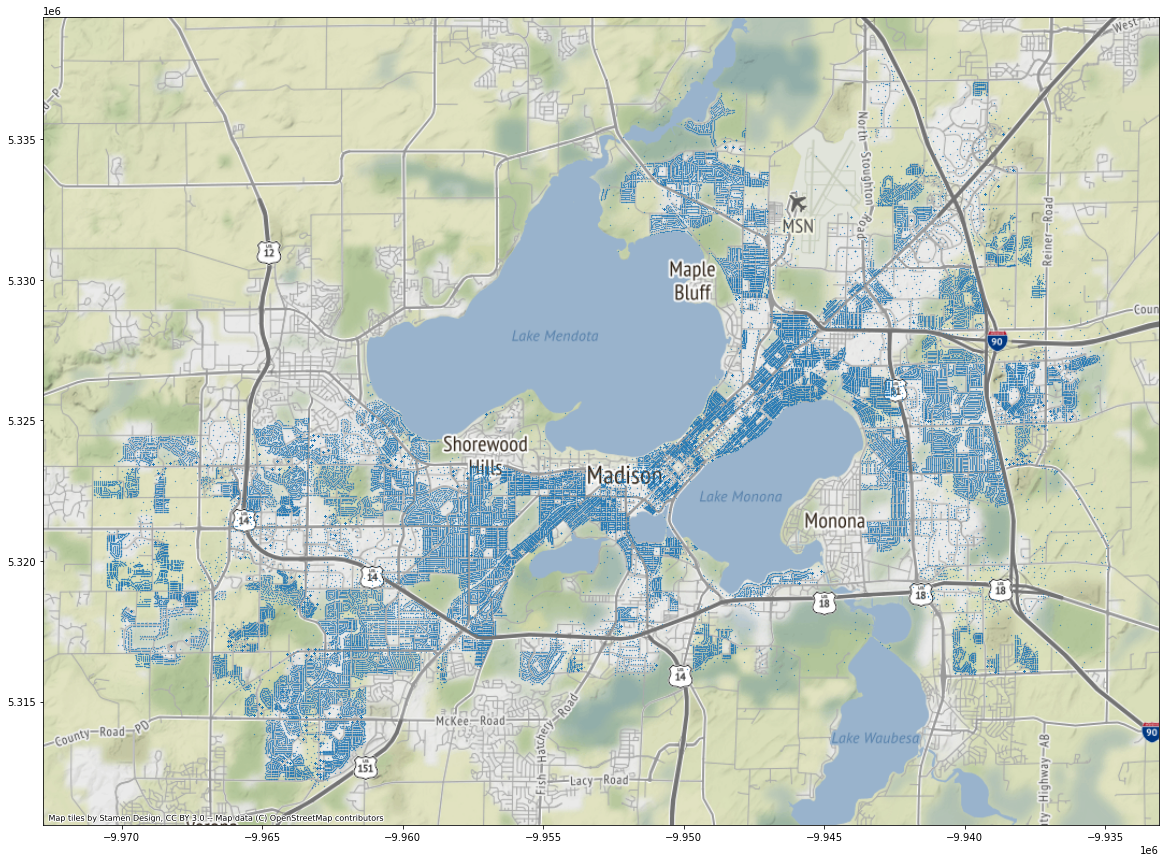

In [9]:
df = df.to_crs(epsg=3857)
ax = df.plot(markersize=0.1, figsize=(20,20))

ctx.add_basemap(ax)